In [4]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx

# Define the physical constants
E = 1e5  # Young's modulus (Pa)
nu = 0.3  # Poisson's ratio
L = 25.0  # Length of the plate (m)
H = 1.0  # Height of the plate (m)
P = 1  # Applied load (N)
lambda_reg = 0.1  # Regularization parameter
rho = 1.0  # Density
g = 9.81  # Gravity acceleration

# Characteristic scales for non-dimensionalization
sigma_char = E
x_char = L
y_char = H
u_char = P * L / E

# Non-dimensionalize function
def nondimensionalize(val, char):
    return val / char

# Dimensionalize functions
def dimensionalize_displacement(u_nd, v_nd):
    return u_nd * u_char, v_nd * u_char

def dimensionalize_stress(sigma_xx_nd, sigma_yy_nd, sigma_xy_nd):
    return sigma_xx_nd * sigma_char, sigma_yy_nd * sigma_char, sigma_xy_nd * sigma_char

# Define the Separable PINN model for X and Y latent matrices
class SeparablePINN(eqx.Module):
    x_net: eqx.nn.MLP
    y_net: eqx.nn.MLP
    latent_size: int

    def __init__(self, key, latent_size=128):
        keys = jax.random.split(key, 6)
        self.latent_size = latent_size
        # X Network
        self.x_net = eqx.nn.MLP(
            in_size=2, out_size=latent_size * 2, width_size=128, depth=3, key=keys[0]
        )
        # Y Network
        self.y_net = eqx.nn.MLP(
            in_size=2, out_size=latent_size * 2, width_size=128, depth=3, key=keys[1]
        )

    def __call__(self, x, y):
        # Generate latent matrices for both X and Y
        x_latent_matrix = self.x_net(jnp.stack([x, y], axis=-1))
        y_latent_matrix = self.y_net(jnp.stack([x, y], axis=-1))

        # Reshape latent matrices to (latent_size, 2)
        x_latent_matrix = x_latent_matrix.reshape(self.latent_size, 2)
        y_latent_matrix = y_latent_matrix.reshape(self.latent_size, 2)

        # Combine latent matrices using element-wise multiplication and sum across latent axis
        final_output = jnp.einsum('ij,ij->j', x_latent_matrix, y_latent_matrix)
        return final_output

# Calculate the PDE residuals to enforce the equilibrium equations
def pde_residual(model, x, y):
    displacement = model(x, y)
    u, v = displacement[0], displacement[1]

    grad_u_x = jax.grad(lambda x: model(x, y)[0])(x)
    grad_v_y = jax.grad(lambda y: model(x, y)[1])(y)

    # Strain components in 2D
    epsilon_xx = grad_u_x
    epsilon_yy = grad_v_y

    # Residuals for the equilibrium equations
    res_x = epsilon_xx
    res_y = epsilon_yy + g

    return res_x, res_y

# Define the loss function
def loss_fn(model, x, y):
    x_nd = nondimensionalize(x, x_char)
    y_nd = nondimensionalize(y, y_char)

    res_x, res_y = jax.vmap(pde_residual, in_axes=(None, 0, 0))(model, x_nd, y_nd)
    pde_loss = jnp.mean(res_x**2 + res_y**2)

    # Boundary condition penalties (increased penalty)
    def left_boundary_loss(y):
        return jnp.square(model(0.0, y)[0])

    def bottom_boundary_loss(x):
        return jnp.square(model(x, 0.0)[1])

    u_v_left = jax.vmap(left_boundary_loss)(y_nd)
    u_v_bottom = jax.vmap(bottom_boundary_loss)(x_nd)
    
    bc_loss = 10 * (
        jnp.mean(u_v_left) +  # Increased penalty for the fixed left edge
        jnp.mean(u_v_bottom)  # Increased penalty for the fixed bottom edge in y-direction
    )

    # Properly extract parameters for L2 regularization
    params = eqx.filter(model, eqx.is_inexact_array)
    l2_reg = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

    total_loss = pde_loss + bc_loss + lambda_reg * l2_reg
    return total_loss

# Calculate loss and gradients
@eqx.filter_value_and_grad
def loss_and_grad(model, x, y):
    return loss_fn(model, x, y)

# Define a single training step
@eqx.filter_jit
def train_step(model, opt_state, x, y):
    loss, grads = loss_and_grad(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# Initialize model and optimizer
key = jax.random.PRNGKey(0)
model = SeparablePINN(key)
optimizer = optax.adam(1e-4)  # Adjusted learning rate
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Training data
x_train = jnp.linspace(0, L, 200)
y_train = jnp.linspace(0, H, 200)

# Training loop
num_epochs = 5500
for epoch in range(num_epochs):
    model, opt_state, loss = train_step(model, opt_state, x_train, y_train)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")



Epoch 0, Loss: 142.6859893798828
Epoch 100, Loss: 41.6553840637207
Epoch 200, Loss: 34.29874801635742
Epoch 300, Loss: 29.672548294067383
Epoch 400, Loss: 26.09383773803711
Epoch 500, Loss: 23.282684326171875
Epoch 600, Loss: 21.037416458129883
Epoch 700, Loss: 19.24968147277832
Epoch 800, Loss: 17.762653350830078
Epoch 900, Loss: 16.52020263671875
Epoch 1000, Loss: 15.457637786865234
Epoch 1100, Loss: 14.535572052001953
Epoch 1200, Loss: 13.722273826599121
Epoch 1300, Loss: 12.976459503173828
Epoch 1400, Loss: 12.28410816192627
Epoch 1500, Loss: 11.64498233795166
Epoch 1600, Loss: 11.048352241516113
Epoch 1700, Loss: 10.483688354492188
Epoch 1800, Loss: 9.957542419433594
Epoch 1900, Loss: 9.451948165893555
Epoch 2000, Loss: 8.978086471557617
Epoch 2100, Loss: 8.523869514465332
Epoch 2200, Loss: 8.106230735778809
Epoch 2300, Loss: 7.705135345458984
Epoch 2400, Loss: 7.32205867767334
Epoch 2500, Loss: 6.965810775756836
Epoch 2600, Loss: 6.628058910369873
Epoch 2700, Loss: 6.316909313201

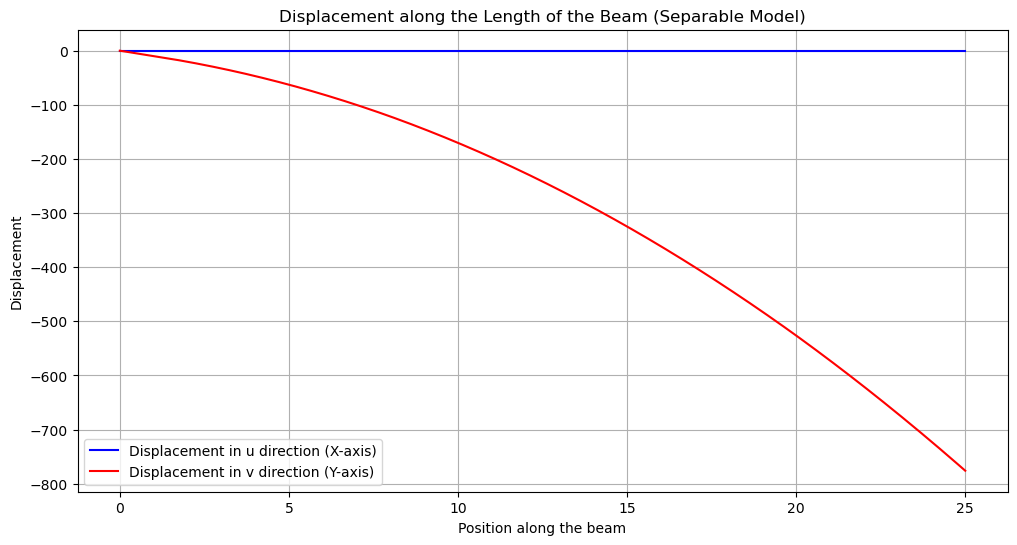

In [8]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Adjusted function to plot the displacement along the beam
def plot_displacement_along_x_and_y(model):
    x_vals = jnp.linspace(0, 25, 500)
    y_vals = jnp.linspace(0, 1, 20)
    x_vals2 = jnp.linspace(0, 1, 20)
    y_vals2 = jnp.linspace(0, 25, 500)

    u_displacement = np.array([model(x, y)[0] for x in x_vals for y in y_vals]).reshape(500, 20)
    v_displacement = np.array([model(x, y)[1] for y in y_vals2 for x in x_vals2]).reshape(500, 20)

    u_mean = u_displacement.mean(axis=1)
    v_mean = v_displacement.mean(axis=1)
   # Generate the points for X and Y axes

    
    plt.figure(figsize=(12, 6))
    plt.plot(x_vals, u_mean, label="Displacement in u direction (X-axis)", color='b')
    plt.plot(x_vals, v_mean, label="Displacement in v direction (Y-axis)", color='r')
    plt.title("Displacement along the Length of the Beam (Separable Model)")
    plt.xlabel("Position along the beam")
    plt.ylabel("Displacement")
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Call the function with your trained model
plot_displacement_along_x_and_y(model)


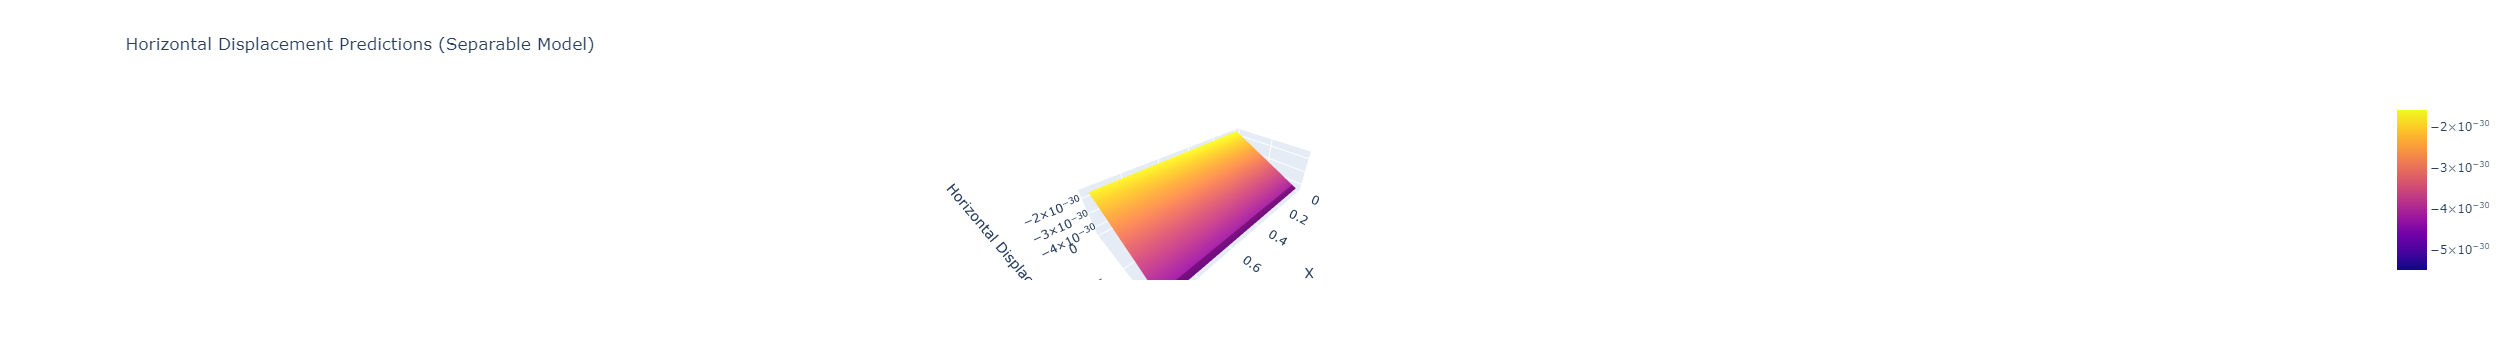

In [13]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

# Visualization (to be adapted to your specific needs)
def visualize_horizontal_displacement_separable(model, x_points=500, y_points=20):
    # Generate the points for X and Y axes
    x_vals = jnp.linspace(0, 25, x_points)
    y_vals = jnp.linspace(0, 1, y_points)
    
    # Generate predictions across the mesh grid
    horizontal_displacement = np.array([
        model(x, y)[0] for y in y_vals for x in x_vals  # [0] for the horizontal displacement (X-axis)
    ]).reshape(x_points, y_points)
    
    # Prepare data for interactive 3D plot
    fig = go.Figure(data=[go.Surface(z=horizontal_displacement, x=x_vals, y=y_vals)])
    fig.update_layout(
        title="Horizontal Displacement Predictions (Separable Model)",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Horizontal Displacement',
            aspectratio=dict(x=2, y=1, z=0.5)
        )
    )
    fig.show()

# Assuming the model is trained
visualize_horizontal_displacement_separable(model, x_points=500, y_points=20)





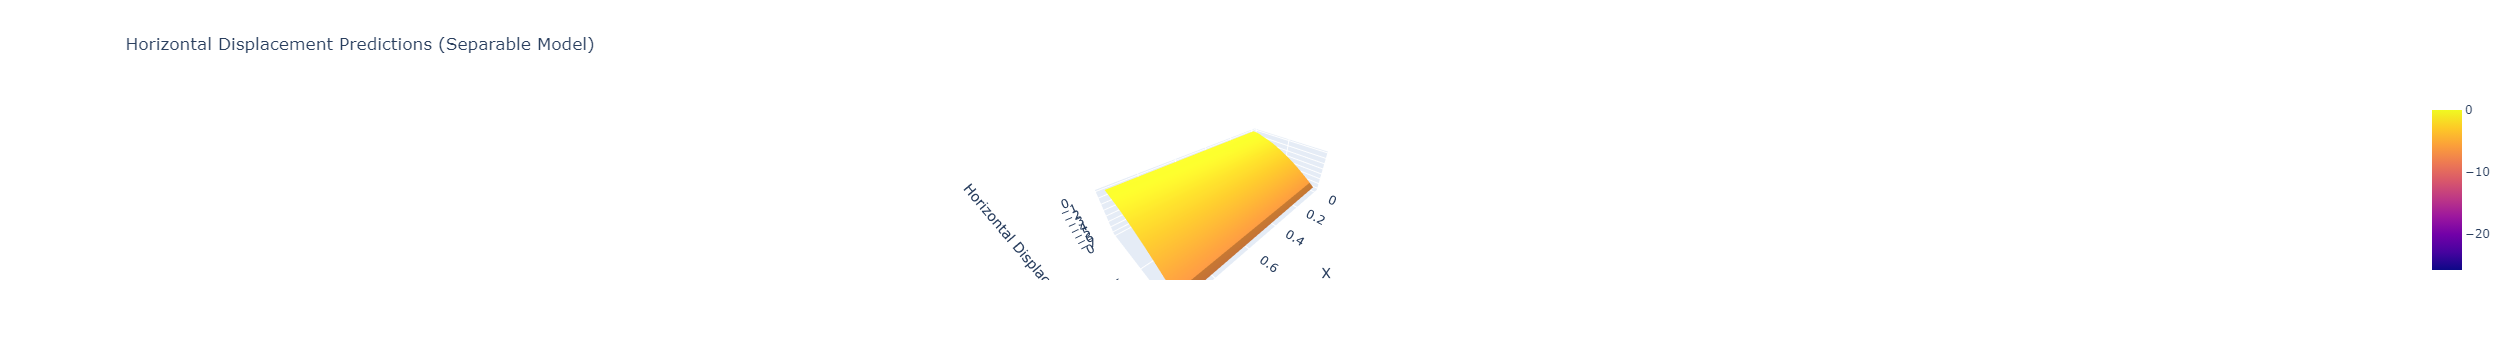

In [12]:
# Visualization (to be adapted to your specific needs)
def visualize_vertical_displacement_separable(model, x_points=500, y_points=20):
    # Generate the points for X and Y axes
    x_vals = jnp.linspace(0, 25, x_points)
    y_vals = jnp.linspace(0, 1, y_points)
    
    # Generate predictions across the mesh grid
    vertical_displacement = np.array([
        model(x, y)[1] for y in y_vals for x in x_vals  # [0] for the horizontal displacement (X-axis)
    ]).reshape(x_points, y_points)
    
    # Prepare data for interactive 3D plot
    fig = go.Figure(data=[go.Surface(z=vertical_displacement, x=x_vals, y=y_vals)])
    fig.update_layout(
        title="Horizontal Displacement Predictions (Separable Model)",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Horizontal Displacement',
            aspectratio=dict(x=2, y=1, z=0.5)
        )
    )
    fig.show()

# Assuming the model is trained
visualize_vertical_displacement_separable(model, x_points=500, y_points=20)
